# Support notebook to get statistics on the protein dataset

In [0]:
import string
import glob

import torch
import torch.nn as nn
from torch.autograd import Variable

import random
import time
import math
import numpy as np

from matplotlib import pyplot as plt

In [2]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")

if use_cuda:
  dvc = torch.cuda.current_device()
  print(torch.cuda.get_device_name(dvc))
  print(torch.cuda.get_device_capability(dvc))
  print(torch.cuda.get_device_properties(dvc))

Running GPU.
Tesla K80
(3, 7)
_CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


## Prep data

In [0]:
all_letters = string.ascii_uppercase
n_letters = len(all_letters) + 1 # Plus EOS marker
EOS = n_letters - 1 # get index of EOS symbol

In [14]:
all_letters

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [15]:
EOS

26

In [0]:
# read a file and split into lines
def read_lines(filename):
  lines = open(filename).read().strip().split('\n')
  lines = [line.replace(' ','') for line in lines] # remove space between the characters
  return lines

In [17]:
# test read of file
test = read_lines('./protein-datasets/arc_full/train.txt')
print(len(test))

1997


In [18]:
# find the categories, i.e. protein groups
all_categories = list()
path = './protein-datasets/'

for foldername in glob.glob(path + '*'):
  categ = foldername.replace(path,'').replace('_full','')
  #print(categ)
  all_categories.append(categ)

print('found protein categories: {}'.format(all_categories))

found protein categories: ['arc', 'bac', 'vir']


In [19]:
n_categories = len(all_categories)
print('Nr. of protein groups (categories) =>', n_categories)

Nr. of protein groups (categories) => 3


In [0]:
# build the category_lines dict, a list of lines per category
category_lines = dict()

for categ in all_categories:
  for file in glob.glob(path + categ + '_full/train.txt'):
    lines = read_lines(file)
    category_lines[categ] = lines

In [21]:
len(category_lines['arc'])

1997

In [22]:
# average, max and min length of protein sequence overall
total_seq_len = 0
max_seq_len = 0
min_seq_len = 99999
total_seq = 0

for categ in all_categories:
  for file in glob.glob(path + categ + '_full/train.txt'):
    lines = read_lines(file)
    total_seq = total_seq + len(lines)
    for line in lines:
      total_seq_len = total_seq_len + len(line)
      if len(line) > max_seq_len:
        max_seq_len = len(line)
      elif len(line) < min_seq_len:
        min_seq_len = len(line)
  for file in glob.glob(path + categ + '_full/valid.txt'):
    lines = read_lines(file)
    total_seq = total_seq + len(lines)
    for line in lines:
      total_seq_len = total_seq_len + len(line)
      if len(line) > max_seq_len:
        max_seq_len = len(line)
      elif len(line) < min_seq_len:
        min_seq_len = len(line)
  for file in glob.glob(path + categ + '_full/test.txt'):
    lines = read_lines(file)
    total_seq = total_seq + len(lines)
    for line in lines:
      total_seq_len = total_seq_len + len(line)
      if len(line) > max_seq_len:
        max_seq_len = len(line)
      elif len(line) < min_seq_len:
        min_seq_len = len(line)

print("total seq length:", total_seq_len)
print("total number of sequences:", total_seq)
print("avg sequence lenght:", total_seq_len / total_seq)
print("max sequence length:", max_seq_len)
print("min sequence length:", min_seq_len)

total seq length: 46585269
total number of sequences: 103382
avg sequence lenght: 450.61295970284965
max sequence length: 16990
min sequence length: 7


In [23]:
# average, min and max length of protein sequence in each domain - bacteria
bac_total_seq_len = 0
bac_max_seq_len = 0
bac_min_seq_len = 99999
bac_total_seq = 0
bac_l = []

# bac
lines = read_lines(glob.glob(path + 'bac' + '_full/train.txt')[0])
bac_total_seq = bac_total_seq + len(lines)
for line in lines:
  bac_l.append(len(line))
  bac_total_seq_len = bac_total_seq_len + len(line)
  if len(line) > bac_max_seq_len:
    bac_max_seq_len = len(line)
  elif len(line) < bac_min_seq_len:
    bac_min_seq_len = len(line)
lines = read_lines(glob.glob(path + 'bac' + '_full/valid.txt')[0])
bac_total_seq = bac_total_seq + len(lines)
for line in lines:
  bac_l.append(len(line))
  bac_total_seq_len = bac_total_seq_len + len(line)
  if len(line) > bac_max_seq_len:
    bac_max_seq_len = len(line)
  elif len(line) < bac_min_seq_len:
    bac_min_seq_len = len(line)
lines = read_lines(glob.glob(path + 'bac' + '_full/test.txt')[0])
bac_total_seq = bac_total_seq + len(lines)
for line in lines:
  bac_l.append(len(line))
  bac_total_seq_len = bac_total_seq_len + len(line)
  if len(line) > bac_max_seq_len:
    bac_max_seq_len = len(line)
  elif len(line) < bac_min_seq_len:
    bac_min_seq_len = len(line)

print('-- bacteria --')
print("total seq length:", bac_total_seq_len)
print("total number of sequences:", bac_total_seq)
print("avg sequence lenght:", bac_total_seq_len / bac_total_seq)
print("max sequence length:", bac_max_seq_len)
print("min sequence length:", bac_min_seq_len)

-- bacteria --
total seq length: 34113615
total number of sequences: 69785
avg sequence lenght: 488.8387905710396
max sequence length: 16990
min sequence length: 7


In [24]:
# average, min and max length of protein sequence in each domain - vira
vir_total_seq_len = 0
vir_max_seq_len = 0
vir_min_seq_len = 99999
vir_total_seq = 0
vir_l = []

# vir
lines = read_lines(glob.glob(path + 'vir' + '_full/train.txt')[0])
vir_total_seq = vir_total_seq + len(lines)
for line in lines:
  vir_l.append(len(line))
  vir_total_seq_len = vir_total_seq_len + len(line)
  if len(line) > vir_max_seq_len:
    vir_max_seq_len = len(line)
  elif len(line) < vir_min_seq_len:
    vir_min_seq_len = len(line)
lines = read_lines(glob.glob(path + 'vir' + '_full/valid.txt')[0])
vir_total_seq = vir_total_seq + len(lines)
for line in lines:
  vir_l.append(len(line))
  vir_total_seq_len = vir_total_seq_len + len(line)
  if len(line) > vir_max_seq_len:
    vir_max_seq_len = len(line)
  elif len(line) < vir_min_seq_len:
    vir_min_seq_len = len(line)
lines = read_lines(glob.glob(path + 'vir' + '_full/test.txt')[0])
vir_total_seq = vir_total_seq + len(lines)
for line in lines:
  vir_l.append(len(line))
  vir_total_seq_len = vir_total_seq_len + len(line)
  if len(line) > vir_max_seq_len:
    vir_max_seq_len = len(line)
  elif len(line) < vir_min_seq_len:
    vir_min_seq_len = len(line)

print('-- vira --')
print("total seq length:", vir_total_seq_len)
print("total number of sequences:", vir_total_seq)
print("avg sequence lenght:", vir_total_seq_len / vir_total_seq)
print("max sequence length:", vir_max_seq_len)
print("min sequence length:", vir_min_seq_len)

-- vira --
total seq length: 11387848
total number of sequences: 30283
avg sequence lenght: 376.04755143149623
max sequence length: 7180
min sequence length: 14


In [25]:
# average, min and max length of protein sequence in each domain - archaeas
arc_total_seq_len = 0
arc_max_seq_len = 0
arc_min_seq_len = 99999
arc_total_seq = 0
arc_l = []

# vir
lines = read_lines(glob.glob(path + 'arc' + '_full/train.txt')[0])
arc_total_seq = arc_total_seq + len(lines)
for line in lines:
  arc_l.append(len(line))
  arc_total_seq_len = arc_total_seq_len + len(line)
  if len(line) > arc_max_seq_len:
    arc_max_seq_len = len(line)
  elif len(line) < arc_min_seq_len:
    arc_min_seq_len = len(line)
lines = read_lines(glob.glob(path + 'arc' + '_full/valid.txt')[0])
arc_total_seq = arc_total_seq + len(lines)
for line in lines:
  arc_l.append(len(line))
  arc_total_seq_len = arc_total_seq_len + len(line)
  if len(line) > arc_max_seq_len:
    arc_max_seq_len = len(line)
  elif len(line) < arc_min_seq_len:
    arc_min_seq_len = len(line)
lines = read_lines(glob.glob(path + 'arc' + '_full/test.txt')[0])
arc_total_seq = arc_total_seq + len(lines)
for line in lines:
  arc_l.append(len(line))
  arc_total_seq_len = arc_total_seq_len + len(line)
  if len(line) > max_seq_len:
    arc_max_seq_len = len(line)
  elif len(line) < arc_min_seq_len:
    arc_min_seq_len = len(line)

print('-- archaeas --')
print("total seq length:", arc_total_seq_len)
print("total number of sequences:", arc_total_seq)
print("avg sequence lenght:", arc_total_seq_len / arc_total_seq)
print("max sequence length:", arc_max_seq_len)
print("min sequence length:", arc_min_seq_len)

-- archaeas --
total seq length: 1083806
total number of sequences: 3314
avg sequence lenght: 327.038624019312
max sequence length: 2951
min sequence length: 29


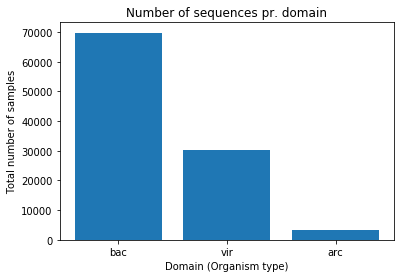

In [0]:
# how many unique sequences do we have?
# total = 103.382
# bac = 69.785
# vir = 30.283
# arc = 3314

plt.bar(['bac', 'vir', 'arc'],[bac_total_seq, vir_total_seq, arc_total_seq])
plt.title('Number of sequences pr. domain')
plt.xlabel('Domain (Organism type)')
plt.ylabel('Total number of samples')
plt.show()

In [0]:
# sequence length
# average sequence length across all three domains: 450.61295970284965
# max sequence length across all three domains: 16990
# min sequence length across all three domains: 7

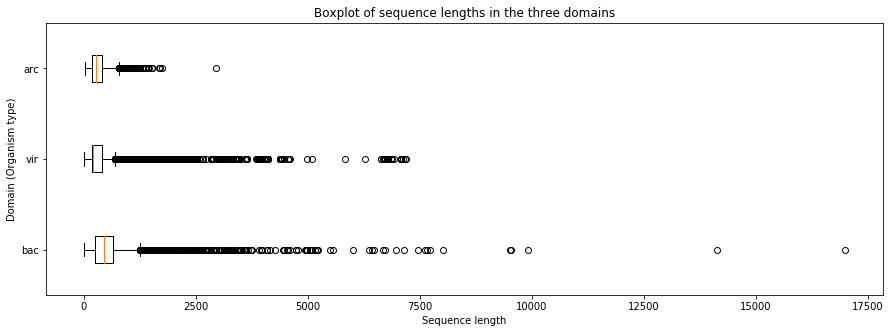

In [0]:
plt.figure(figsize=(15,5))
plt.boxplot([bac_l, vir_l, arc_l],vert=False, labels=['bac','vir','arc'])
plt.title('Boxplot of sequence lengths in the three domains')
plt.xlabel('Sequence length')
plt.ylabel('Domain (Organism type)')
plt.savefig('boxplot-full.png', format='png')
plt.show()

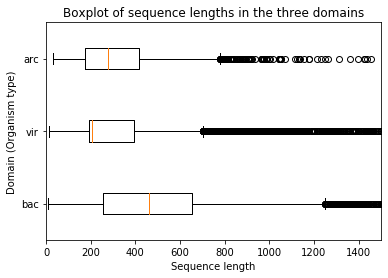

In [0]:
#plt.figure(figsize=(8,3))
data = [bac_l, vir_l, arc_l]
plt.boxplot(data,vert=False, labels=['bac','vir','arc'], manage_ticks=True)
plt.xticks(np.arange(0, 17000, 200))
plt.title('Boxplot of sequence lengths in the three domains')
plt.xlabel('Sequence length')
plt.ylabel('Domain (Organism type)')
plt.xlim([0,1500])
plt.savefig('boxplot-cut.png',format='png')
plt.show()